# Identifying Patterns of Crime Against Women in India
*by Adeline Liem*

The identification of crime hotspots is crucial for developing effective law enforcement strategies and ensuring public safety. This project focuses on detecting clusters of states with similar patterns of crimes against women in India, using data from 2001 to 2021. The dataset includes specific crime categories such as Rape, Kidnapping/Abduction, Dowry Deaths, Assault on Women, Domestic Violence, and Women Trafficking. 

The central questions guiding this investigation include: Which states exhibit similar patterns of these crimes? Can states be categorized into distinct clusters based on the type and frequency of crimes against women? To explore these questions, I will employ K-Means clustering to group states according to their crime statistics. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly
from plotly import express as px
from plotly.subplots import make_subplots

import ast

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

# General imports for clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering

# Import for scaling/normalizing data
from sklearn.preprocessing import StandardScaler

# Optional import for dimensionality reduction (if needed)
from sklearn.decomposition import PCA

# Import for evaluating the quality of the clusters (if needed)
from sklearn.metrics import silhouette_score


# Data Wrangling

In this section, I imported and cleaned the data to make my data analysis more efficient and clear. In addition to dropping irrelevant columns, I also made sure to standardize the formatting of any strings in the dataset. Finally, I organized the states into various regions in India.

This dataset comes from Kaggle and was collated by Balaji Vara Prasad Dega.

Link: https://www.kaggle.com/datasets/balajivaraprasad/crimes-against-women-in-india-2001-2021/data

In [2]:
# Reading dataset
crimes_ds = pd.read_csv("CrimesOnWomenData.csv")
crimes_ds.head()

,Unnamed: 0,State,Year,Rape,K&A,DD,AoW,AoM,DV,WT
0,0,ANDHRA PRADESH,2001,871,765,420,3544,2271,5791,7
1,1,ARUNACHAL PRADESH,2001,33,55,0,78,3,11,0
2,2,ASSAM,2001,817,1070,59,850,4,1248,0
3,3,BIHAR,2001,888,518,859,562,21,1558,83
4,4,CHHATTISGARH,2001,959,171,70,1763,161,840,0


In [3]:
crimes_ds.shape

(736, 10)

In [4]:
# Dropping unnecessary columns
crimes_ds = crimes_ds.drop(columns=['Unnamed: 0', 'AoM'])

In [5]:
# Renaming columns
crimes_ds.rename(columns={
    'Rape': 'Rape',
    'K&A': 'Kidnapping_Abduction',
    'DD': 'Dowry_Deaths',
    'AoW': 'Assault_Women',
    'AoM': 'Assault_Minors',
    'DV': 'Domestic_Violence',
    'WT': 'Women_Trafficking'
}, inplace=True)

In [6]:
# Standardize capitalization of states
crimes_ds['State'] = crimes_ds['State'].str.upper()

In [7]:
# Check all states have equal numbers of entries
crimes_ds['State'].value_counts()

State
ANDHRA PRADESH       21
ARUNACHAL PRADESH    21
ASSAM                21
BIHAR                21
CHHATTISGARH         21
GOA                  21
GUJARAT              21
HARYANA              21
HIMACHAL PRADESH     21
JAMMU & KASHMIR      21
JHARKHAND            21
KARNATAKA            21
KERALA               21
MADHYA PRADESH       21
MAHARASHTRA          21
MANIPUR              21
MEGHALAYA            21
MIZORAM              21
NAGALAND             21
ODISHA               21
PUNJAB               21
RAJASTHAN            21
SIKKIM               21
TAMIL NADU           21
TRIPURA              21
UTTAR PRADESH        21
UTTARAKHAND          21
WEST BENGAL          21
A & N ISLANDS        21
CHANDIGARH           21
DAMAN & DIU          21
LAKSHADWEEP          21
PUDUCHERRY           21
D&N HAVELI           11
TELANGANA            11
DELHI UT             11
D & N HAVELI         10
Name: count, dtype: int64

In [8]:
# Replace entries with correct formatting
crimes_ds['State'] = crimes_ds['State'].replace('D & N HAVELI', 'D&N HAVELI')
crimes_ds['State'] = crimes_ds['State'].replace('A & N ISLANDS', 'A&N ISLANDS')

In [9]:
# Drop entries with states that have missing data
crimes_ds = crimes_ds.drop(crimes_ds[(crimes_ds['State'] == 'TELANGANA') | (crimes_ds['State'] == 'DELHI UT')].index)

In [10]:
# Define the regions in India and assign states to them
region_mapping = {
    'North': ['JAMMU & KASHMIR', 'HIMACHAL PRADESH', 'PUNJAB', 'CHANDIGARH', 'UTTARAKHAND', 'HARYANA', 'DELHI', 'DELHI UT', 'UTTAR PRADESH'],
    'South': ['ANDHRA PRADESH', 'KARNATAKA', 'KERALA', 'TAMIL NADU', 'TELANGANA', 'PUDUCHERRY', 'LAKSHADWEEP'],
    'East': ['BIHAR', 'JHARKHAND', 'ODISHA', 'WEST BENGAL'],
    'West': ['RAJASTHAN', 'GUJARAT', 'GOA', 'MAHARASHTRA'],
    'Central': ['MADHYA PRADESH', 'CHHATTISGARH'],
    'North-East': ['ARUNACHAL PRADESH', 'ASSAM', 'MANIPUR', 'MEGHALAYA', 
                   'MIZORAM', 'NAGALAND', 'TRIPURA', 'SIKKIM'],
    'Union Territories': ['A&N ISLANDS', 'D&N HAVELI', 'DAMAN & DIU', 'LAKSHADWEEP']
}

# Function to assign regions based on the state name
def assign_region(state):
    for region, states in region_mapping.items():
        if state in states:
            return region
    return 'Unknown'  # Default value if the state is not found in any region

# Add a new column 'Region' to the dataset
crimes_ds['Region'] = crimes_ds['State'].apply(assign_region)

# Reorder columns to place 'Region' after 'State'
columns = crimes_ds.columns.tolist()  # Get the list of column names

# Find the index of 'State' and insert 'Region' right after it
state_index = columns.index('State') + 1
columns.insert(state_index, columns.pop(columns.index('Region')))  # Move 'Region' column

# Reorder the dataframe with the new column order
crimes_ds = crimes_ds[columns]


In [11]:
# Checking for missing values
missing_values = crimes_ds.isnull().sum()
missing_values

State                   0
Region                  0
Year                    0
Rape                    0
Kidnapping_Abduction    0
Dowry_Deaths            0
Assault_Women           0
Domestic_Violence       0
Women_Trafficking       0
dtype: int64

# Exploratory Data Analysis

In this section, I aimed to begin to understand the underlying patterns, relationships, and structures within the dataset. I generated several plots to help visualize the distribution of variables and their relationships to one another. 

In [58]:
crimes_ds.head()

,State,Region,Year,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
0,ANDHRA PRADESH,South,2001,871,765,420,3544,5791,7
1,ARUNACHAL PRADESH,North-East,2001,33,55,0,78,11,0
2,ASSAM,North-East,2001,817,1070,59,850,1248,0
3,BIHAR,East,2001,888,518,859,562,1558,83
4,CHHATTISGARH,Central,2001,959,171,70,1763,840,0


In [12]:
# Checking to see each state has even representation across the years

crimes_ds['State'].value_counts()

State
ANDHRA PRADESH       21
ARUNACHAL PRADESH    21
ASSAM                21
BIHAR                21
CHHATTISGARH         21
GOA                  21
GUJARAT              21
HARYANA              21
HIMACHAL PRADESH     21
JAMMU & KASHMIR      21
JHARKHAND            21
KARNATAKA            21
KERALA               21
MADHYA PRADESH       21
MAHARASHTRA          21
MANIPUR              21
MEGHALAYA            21
MIZORAM              21
NAGALAND             21
ODISHA               21
PUNJAB               21
RAJASTHAN            21
SIKKIM               21
TAMIL NADU           21
TRIPURA              21
UTTAR PRADESH        21
UTTARAKHAND          21
WEST BENGAL          21
A&N ISLANDS          21
CHANDIGARH           21
D&N HAVELI           21
DAMAN & DIU          21
LAKSHADWEEP          21
PUDUCHERRY           21
Name: count, dtype: int64

In [13]:
crimes_ds.describe()

,Year,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
count,714.000000,714.000000,714.00000,714.000000,714.00000,714.000000,714.000000
mean,2011.000000,724.235294,1117.40056,218.375350,1557.77591,2575.046218,28.273109
std,6.059546,983.621236,2001.94923,430.563451,2475.92523,4072.183792,80.040923
min,2001.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
25%,2006.000000,35.000000,24.25000,1.000000,34.25000,13.000000,0.000000
50%,2011.000000,333.500000,282.00000,28.000000,378.00000,651.500000,0.000000
75%,2016.000000,1050.750000,1159.75000,261.750000,1942.00000,3472.250000,13.000000
max,2021.000000,6337.000000,15381.00000,2524.000000,14853.00000,23278.000000,549.000000


/tmp/ipykernel_189/1420807217.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = crimes_ds,


Text(0, 0.5, 'Count of States')

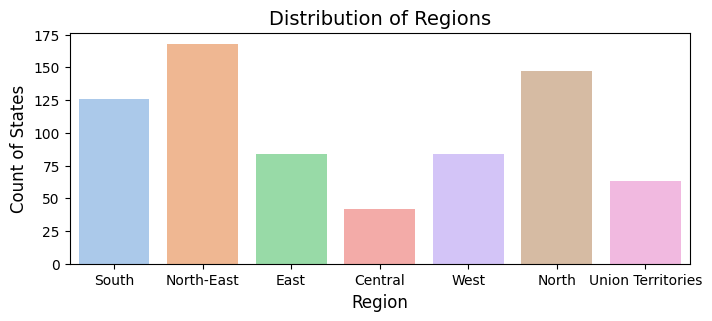

In [60]:
# Distribution of regions
plt.figure(figsize =(8,3))
sns.countplot(data = crimes_ds,
           x = "Region",
             palette="pastel")

# Add title and labels
plt.title('Distribution of Regions', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count of States', fontsize=12)


After checking that all of the states were equally represented in the dataset, I was interested to see the distribution of states per region. This could help inform whether some regions might have higher rates of crime simply because they encompass more states, potentially skewing the overall crime statistics and misleading any conclusions about regional crime trends! One way this could be supplemented is with population count and demographic information per state, but the dataset lacks this information. 

In [15]:
# Looking at crime proportions by region

# Calculate the total crimes for each region without altering the original dataframe
total_crimes_by_region = crimes_ds.groupby('Region')[['Rape', 'Kidnapping_Abduction', 'Dowry_Deaths', 'Assault_Women', 'Domestic_Violence', 'Women_Trafficking']].sum()

# Create a new dataframe for proportions
crime_proportions_df = total_crimes_by_region.div(total_crimes_by_region.sum(axis=1), axis=0).reset_index()

crime_proportions_df

,Region,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
0,Central,0.202103,0.152674,0.031172,0.382216,0.230806,0.001029
1,East,0.108430,0.200795,0.054401,0.190727,0.442640,0.003007
2,North,0.114300,0.250348,0.056180,0.208967,0.368341,0.001865
3,North-East,0.109117,0.231278,0.018241,0.228630,0.410301,0.002434
4,South,0.088892,0.092137,0.023516,0.320984,0.461664,0.012807
5,Union Territories,0.113720,0.310193,0.010042,0.274626,0.289706,0.001713
6,West,0.108437,0.147983,0.016379,0.224885,0.497927,0.004389


<Figure size 800x500 with 0 Axes>

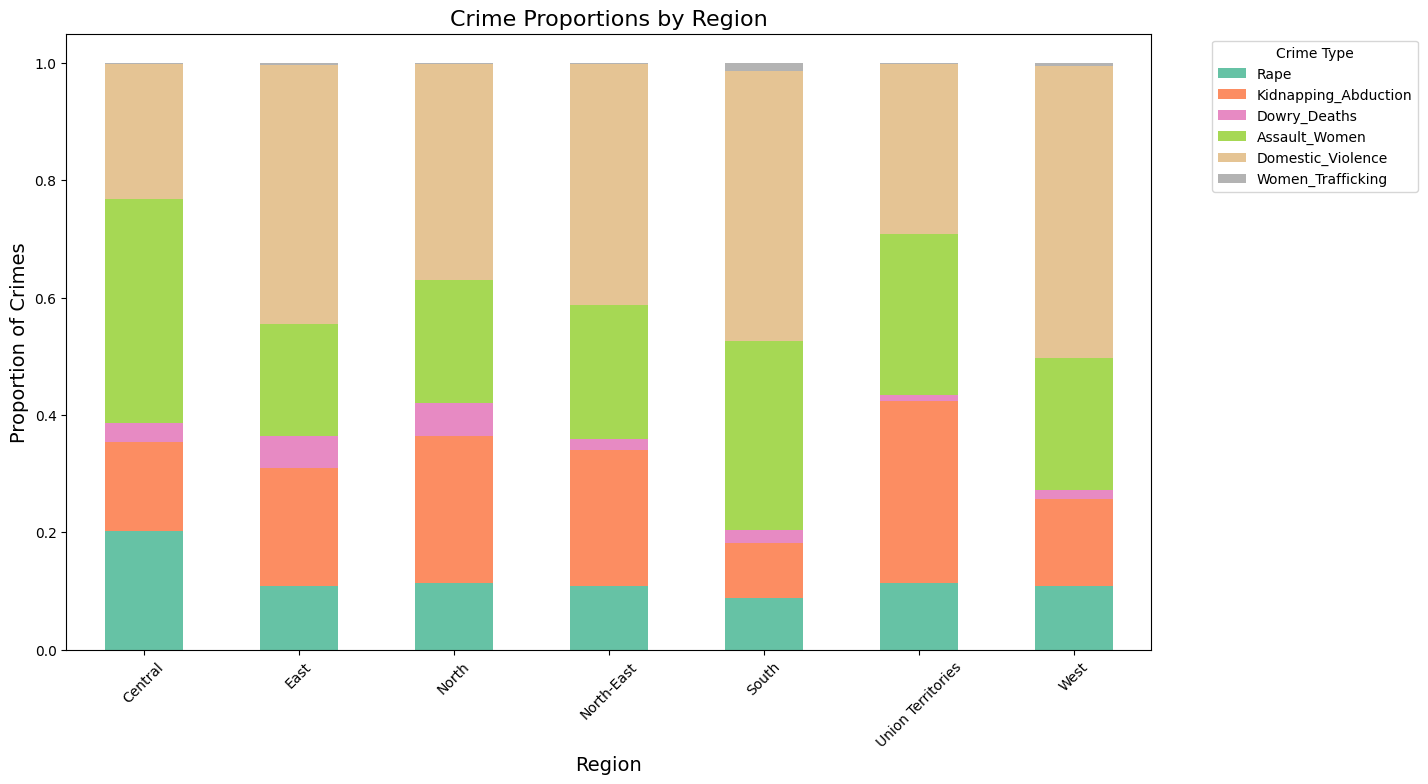

In [38]:
# Visualizing the proportions of crime by region

# Set the figure size
plt.figure(figsize=(8, 5))

# Create a stacked bar plot
crime_proportions_df.set_index('Region').plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set2')

# Add titles and labels
plt.title('Crime Proportions by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Proportion of Crimes', fontsize=14)

# Adjust the legend
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Show the plot
plt.show()

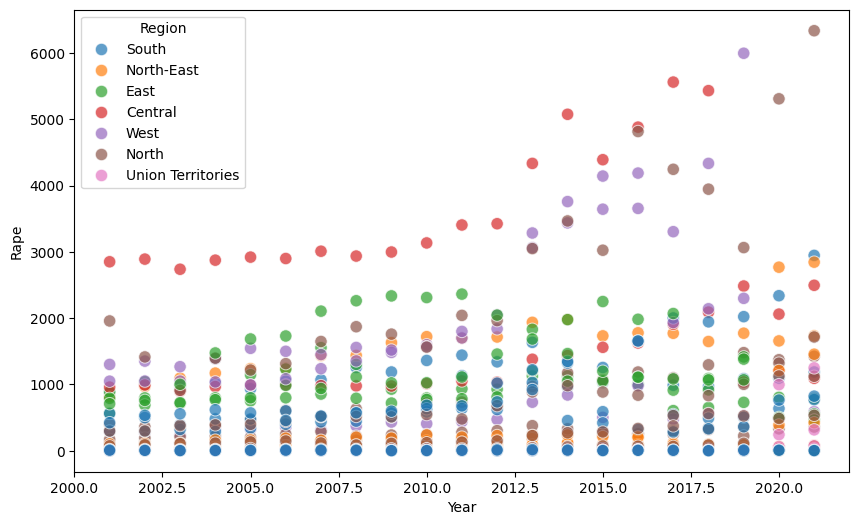

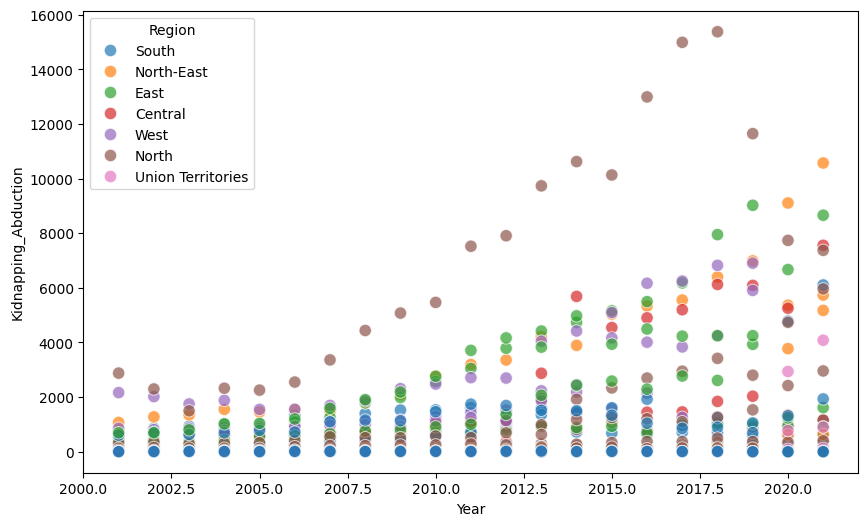

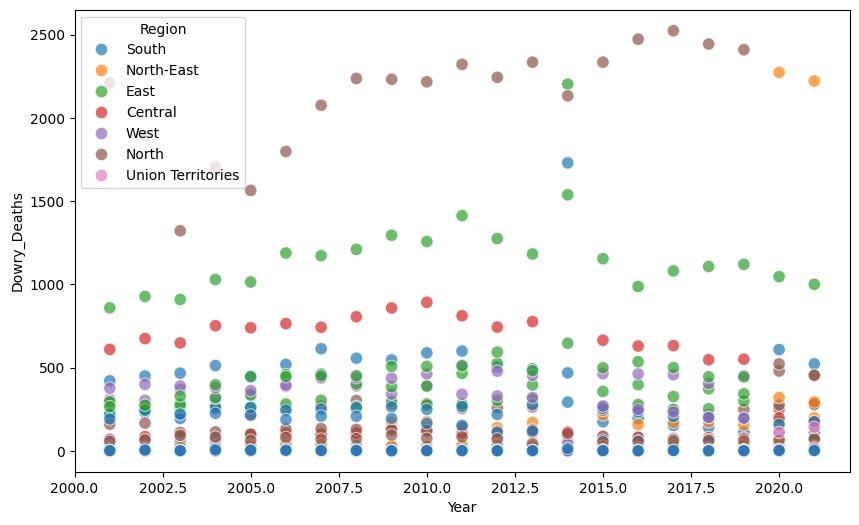

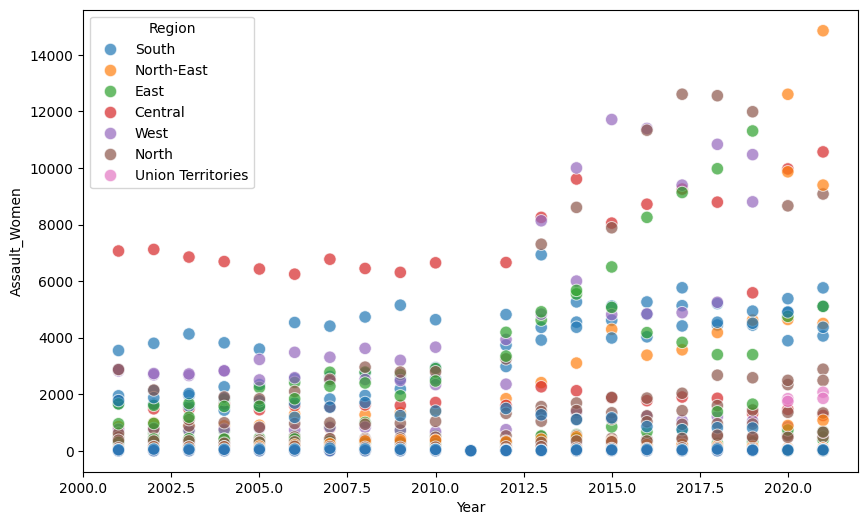

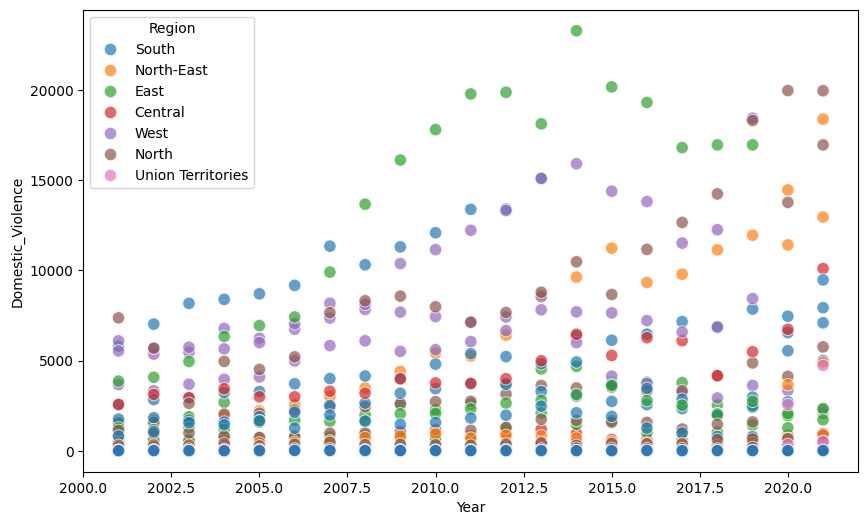

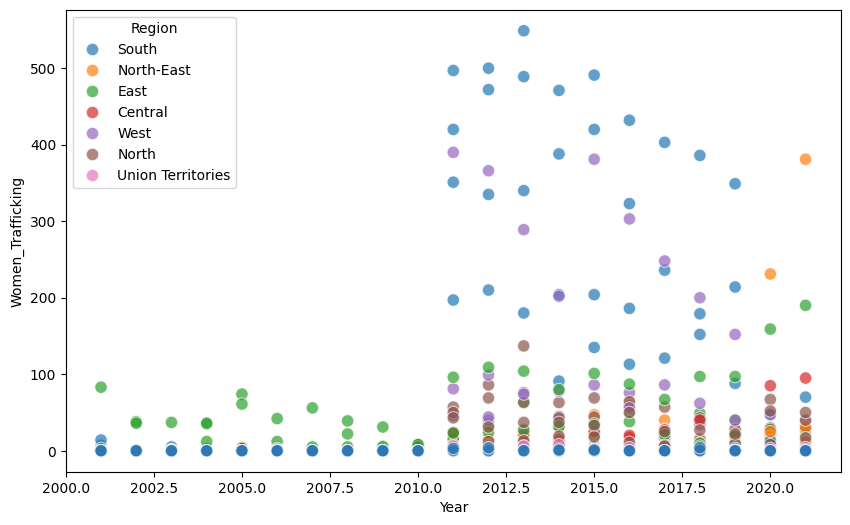

In [17]:
# Crime occurrences by region over time

# List of crime columns to loop through
crime_types = ['Rape', 'Kidnapping_Abduction', 'Dowry_Deaths', 'Assault_Women', 'Domestic_Violence', 'Women_Trafficking']

# Creates new plot for each crime
for crime in crime_types:
    plt.figure(figsize = (10,6))
    
    sns.scatterplot(data = crimes_ds, x = 'Year',
               y = crime, hue = 'Region', alpha = .7, s=80)

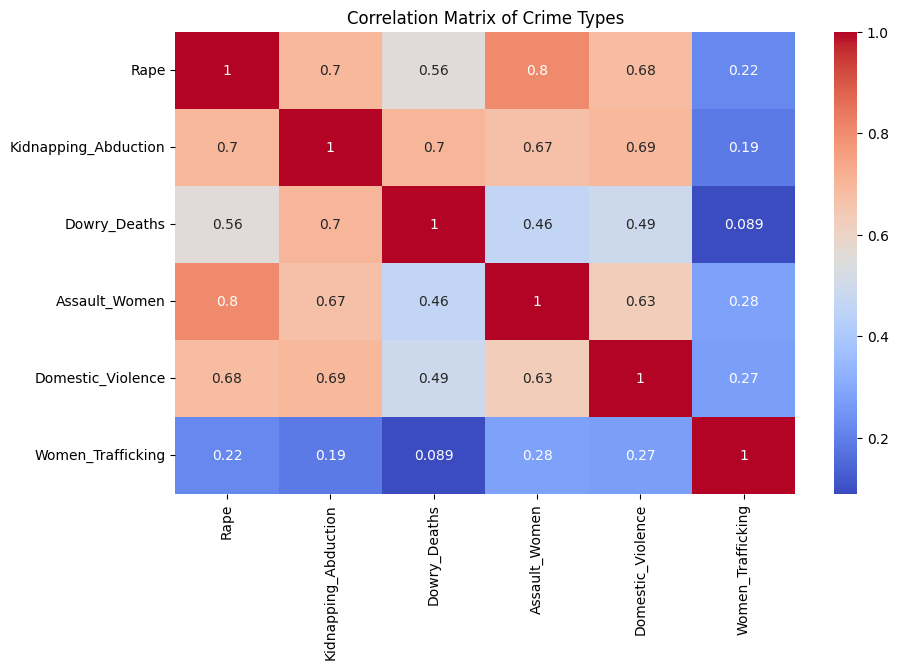

In [18]:
# Calculate correlation matrix
correlation_matrix = crimes_ds[['Rape', 'Kidnapping_Abduction', 'Dowry_Deaths', 'Assault_Women', 'Domestic_Violence', 'Women_Trafficking']].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Crime Types')
plt.show()

# K-Means Clustering

In [19]:
crimes_ds.head()

,State,Region,Year,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
0,ANDHRA PRADESH,South,2001,871,765,420,3544,5791,7
1,ARUNACHAL PRADESH,North-East,2001,33,55,0,78,11,0
2,ASSAM,North-East,2001,817,1070,59,850,1248,0
3,BIHAR,East,2001,888,518,859,562,1558,83
4,CHHATTISGARH,Central,2001,959,171,70,1763,840,0


In [20]:
# Dividing the dataset by years we are interested in

crimes_2001 = crimes_ds[crimes_ds['Year'] == 2001]
crimes_2011 = crimes_ds[crimes_ds['Year'] == 2011]
crimes_2021 = crimes_ds[crimes_ds['Year'] == 2021]

In [21]:
crimes_2001.head()

,State,Region,Year,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
0,ANDHRA PRADESH,South,2001,871,765,420,3544,5791,7
1,ARUNACHAL PRADESH,North-East,2001,33,55,0,78,11,0
2,ASSAM,North-East,2001,817,1070,59,850,1248,0
3,BIHAR,East,2001,888,518,859,562,1558,83
4,CHHATTISGARH,Central,2001,959,171,70,1763,840,0


In [22]:
# Normalize the data
scaler = StandardScaler()

crimes_scaled_2001 = scaler.fit_transform(crimes_2001.iloc[:, 3:])  # Skipping 'State', 'Region', and 'Year' columns
crimes_scaled_2011 = scaler.fit_transform(crimes_2011.iloc[:, 3:])  
crimes_scaled_2021 = scaler.fit_transform(crimes_2021.iloc[:, 3:])  

## 2001

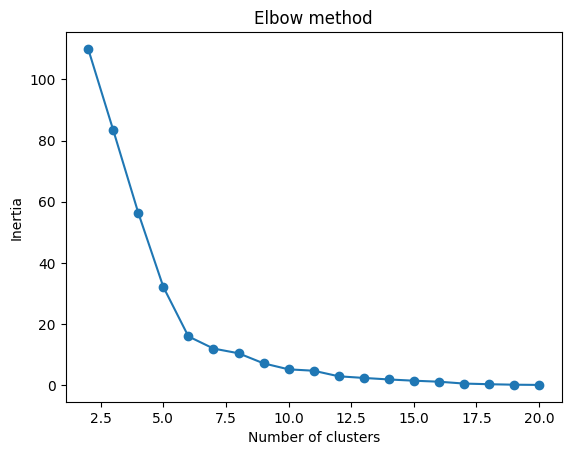

In [23]:
# Elbow method to determine optimal K

sse = []
for k in range(2, 21):
    km = KMeans(n_clusters = k).fit(crimes_scaled_2001)
    sse.append(km.inertia_)
    
plt.plot(range(2,21), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

/tmp/ipykernel_189/495691073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_2001['Cluster_2001'] = kmeans.fit_predict(crimes_scaled_2001)


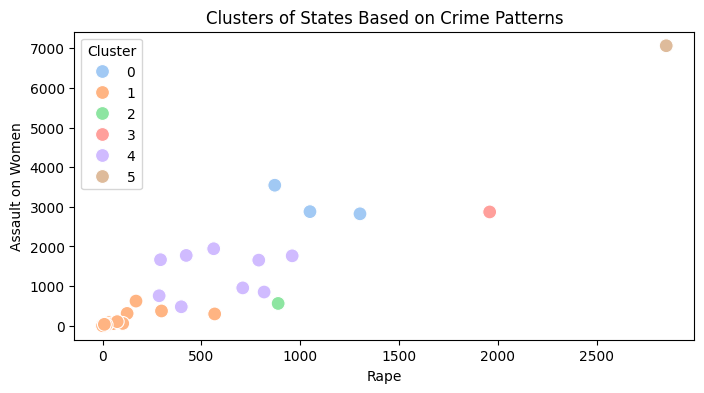

In [39]:
kmeans = KMeans(n_clusters = 6)
crimes_2001['Cluster_2001'] = kmeans.fit_predict(crimes_scaled_2001)

plt.figure(figsize=(8, 4))
sns.scatterplot(x='Rape', y='Assault_Women', hue='Cluster_2001', data=crimes_2001, palette='pastel', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Rape')
plt.ylabel('Assault on Women')
plt.legend(title='Cluster')
plt.show()


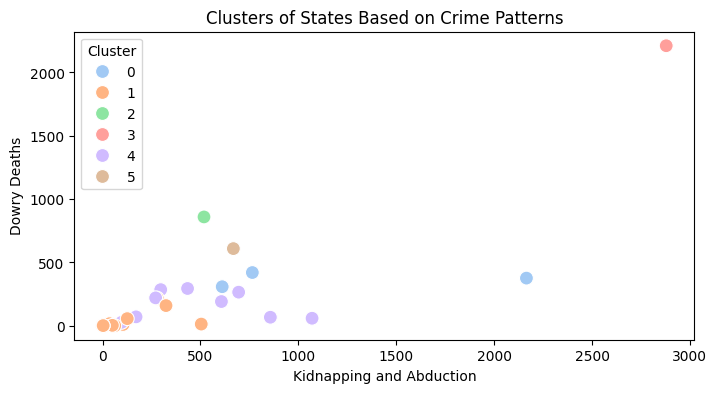

In [40]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Kidnapping_Abduction', y='Dowry_Deaths', hue='Cluster_2001', data=crimes_2001, palette='pastel', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Kidnapping and Abduction')
plt.ylabel('Dowry Deaths')
plt.legend(title='Cluster')
plt.show()

In [26]:
# Display the states grouped by cluster
print(crimes_2001[['State', 'Region','Cluster_2001']].sort_values(by='Cluster_2001'))

                State             Region  Cluster_2001
1   ARUNACHAL PRADESH         North-East             0
5                 GOA               West             0
9     JAMMU & KASHMIR              North             0
8    HIMACHAL PRADESH              North             0
15            MANIPUR         North-East             0
10          JHARKHAND               East             0
31        DAMAN & DIU  Union Territories             0
30         D&N HAVELI  Union Territories             0
24            TRIPURA         North-East             0
26        UTTARAKHAND              North             0
29         CHANDIGARH              North             0
22             SIKKIM         North-East             0
20             PUNJAB              North             0
18           NAGALAND         North-East             0
17            MIZORAM         North-East             0
16          MEGHALAYA         North-East             0
28        A&N ISLANDS  Union Territories             0
32        

After using the Elbow Method to determine an optimal K value of 6, I performed KMeans clustering and visualized the resulting clusters in a scatter plot. Each cluster represents a group of states that have been grouped together based on their similarity in crime patterns. The different regions can be grouped into the following clusters:

- Cluster 0: 19 states (7 Northeast, 5 North, 1 West, 1 East, 3 Union Territories, 2 South)
- Cluster 1: 3 states (1 South, 2 West)
- Cluster 2: 1 state (1 East)
- Cluster 3: 1 state (1 North)
- Cluster 4: 1 state (1 Central)
- Cluster 5: 9 states (3 South, 1 North, 1 Northeast, 2 East, 1 West, 1 Central)

In [50]:
# Mean number of crimes per cluster

crimes_2001[['Rape','Kidnapping_Abduction','Dowry_Deaths','Assault_Women','Domestic_Violence','Women_Trafficking','Cluster_2001']].groupby('Cluster_2001').mean()

,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
Cluster_2001,,,,,,
0,1074.000000,1180.333333,368.000000,3081.666667,5804.333333,3.000000
1,80.947368,82.947368,25.105263,107.684211,137.368421,0.263158
2,888.000000,518.000000,859.000000,562.000000,1558.000000,83.000000
3,1958.000000,2879.000000,2211.000000,2870.000000,7365.000000,0.000000
4,581.888889,499.888889,164.222222,1315.111111,1947.111111,1.888889
5,2851.000000,668.000000,609.000000,7063.000000,2562.000000,0.000000


Then, I computed the average number of each crime against women per cluster type. 


- Cluster 0 has high averages of crime types, especially with notably high observations of assault on women (3081.67) and domestic violence (5804.34).


- We can see that Cluster 1 seems to represent the states with **lowest occurrences of crimes against women**. The means computed for all the crimes in this cluster are the lowest among all clusters, except for women trafficking.


- Cluster 2 has more moderate-high averages of crime types against women, especially in rape (888), dowry deaths (859), and domestic violence (1558). It also may be significant to note that this cluster has the highest aveage of women trafficking amongst all clusters (83).


- Cluster 3 has a **high level of crimes for all crime types against women**, except for women trafficking (0). This cluster has the highest averages for kidnapping/abduction (2879), dowry deaths (2211), and domestic violence (7365).


- Cluster 4 has a mix of moderate and high averages of crime types, except for women trafficking (0). It has the highest average of rape (2851) and assault on women (7063).


- Cluster 5 also has moderate-high averages of crimes against women, with its highest categories being assault on women (1315.11) and domestic violence (1947.11)

## 2011

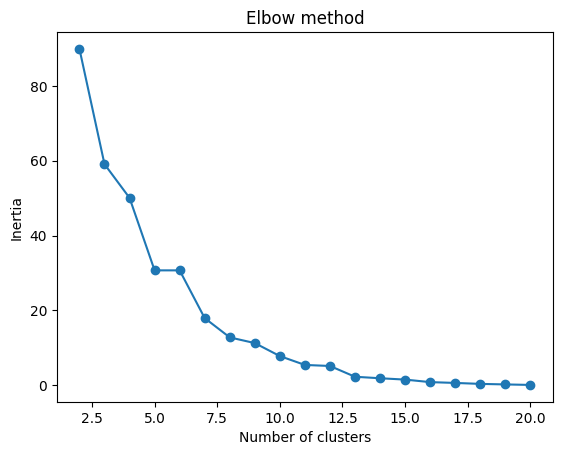

In [28]:
# Elbow method to determine optimal K

sse = []
for k in range(2, 21):
    km = KMeans(n_clusters = k).fit(crimes_scaled_2011)
    sse.append(km.inertia_)
    
plt.plot(range(2,21), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

/tmp/ipykernel_189/3381888006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_2011['Cluster_2011'] = kmeans.fit_predict(crimes_scaled_2011)


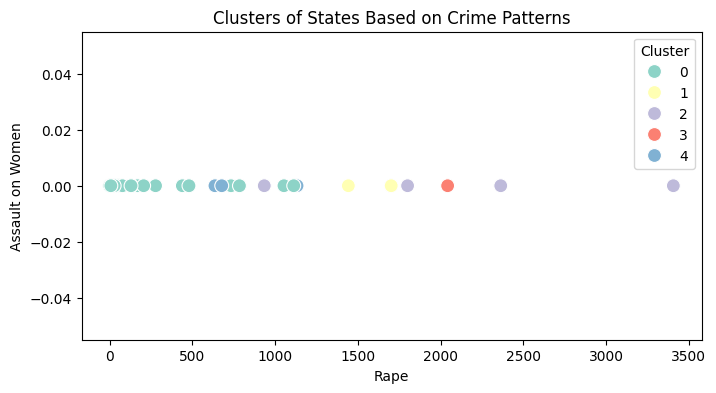

In [44]:
kmeans = KMeans(n_clusters = 5)
crimes_2011['Cluster_2011'] = kmeans.fit_predict(crimes_scaled_2011)

plt.figure(figsize=(8, 4))
sns.scatterplot(x='Rape', y='Assault_Women', hue='Cluster_2011', data=crimes_2011, palette='Set3', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Rape')
plt.ylabel('Assault on Women')
plt.legend(title='Cluster')
plt.show()


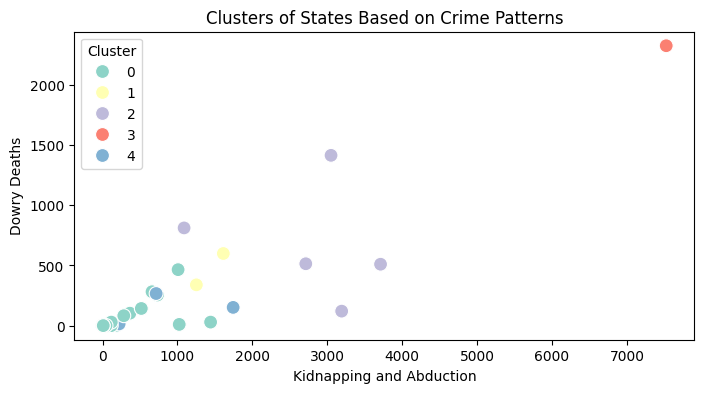

In [45]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Kidnapping_Abduction', y='Dowry_Deaths', hue='Cluster_2011', data=crimes_2011, palette='Set3', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Kidnapping and Abduction')
plt.ylabel('Dowry Deaths')
plt.legend(title='Cluster')
plt.show()


In [66]:
# Display the states grouped by cluster
(crimes_2011[['State', 'Region','Cluster_2011']].sort_values(by='Cluster_2011'))

,State,Region,Cluster_2011
341,ARUNACHAL PRADESH,North-East,0
346,GUJARAT,West,0
345,GOA,West,0
344,CHHATTISGARH,Central,0
347,HARYANA,North,0
350,JHARKHAND,East,0
349,JAMMU & KASHMIR,North,0
348,HIMACHAL PRADESH,North,0
355,MANIPUR,North-East,0
367,UTTARAKHAND,North,0


I used the same Elbow Method formula to calculate the optimal K value for the 2011 data as k = 5, and generated clusters for similar patterns of crimes.


In [48]:
# Mean number of crimes per cluster

crimes_2011[['Rape','Kidnapping_Abduction','Dowry_Deaths','Assault_Women','Domestic_Violence','Women_Trafficking','Cluster_2011']].groupby('Cluster_2011').mean()

,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
Cluster_2011,,,,,,
0,252.217391,289.478261,61.434783,0.0,671.782609,11.260870
1,1571.500000,1432.000000,469.000000,0.0,10256.000000,443.500000
2,2040.600000,2750.800000,673.800000,0.0,8715.000000,49.000000
3,2042.000000,7525.000000,2322.000000,0.0,7121.000000,43.000000
4,815.000000,893.000000,144.666667,0.0,3633.666667,322.666667


After computing the average number of each crime against women for each cluster:

- Cluster 0 appears to represent the states with the **lowest occurrences of crimes against women**. The mean values for all crimes, except domestic violence (671.78), are relatively low, indicating lower crime rates overall in this cluster.


- Cluster 1 shows higher averages across multiple crime types compared to Cluster 0. It is particularly notable for its high averages in domestic violence (10,256) and women trafficking (443.5), suggesting a concentration of these crimes in this cluster.


- Cluster 2 has moderate to high averages for most crime types. It stands out for having high numbers in kidnapping/abduction (2750.8), dowry deaths (673.8), and domestic violence (10256). 


- Cluster 3 is characterized by the **highest averages for 3 out of 6 crime types**, specifically rape (2042), kidnapping/abduction (7525) and dowry deaths (2322). It also has an extremely high average in domestic violence (7121). This cluster represents states with some of the most severe crime rates against women in these categories.


- Cluster 4 shows a mix of moderate crime levels, particularly in kidnapping/abduction (893) and dowry deaths (144.67). It has a notably high average for women trafficking (322.67), suggesting that trafficking is a significant issue in this cluster.

It is also significant to note that **none of the data from this year reports any assault on women**.

## 2021

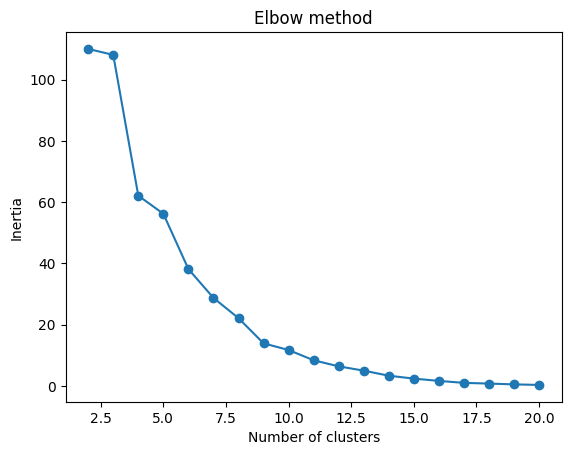

In [32]:
# Elbow method to determine optimal K

sse = []
for k in range(2, 21):
    km = KMeans(n_clusters = k).fit(crimes_scaled_2021)
    sse.append(km.inertia_)
    
plt.plot(range(2,21), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

/tmp/ipykernel_189/2648963557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_2021['Cluster_2021'] = kmeans.fit_predict(crimes_scaled_2021)


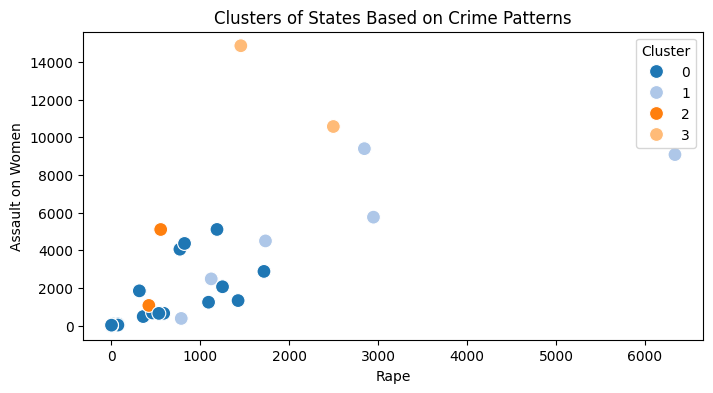

In [46]:
kmeans = KMeans(n_clusters = 4)
crimes_2021['Cluster_2021'] = kmeans.fit_predict(crimes_scaled_2021)

plt.figure(figsize=(8, 4))
sns.scatterplot(x='Rape', y='Assault_Women', hue='Cluster_2021', data=crimes_2021, palette='tab20', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Rape')
plt.ylabel('Assault on Women')
plt.legend(title='Cluster')
plt.show()


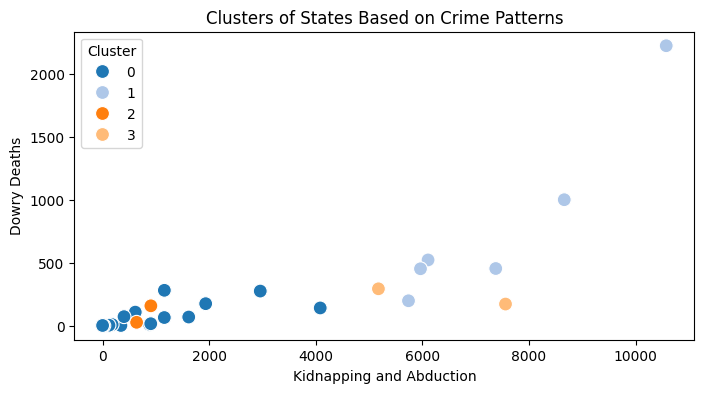

In [47]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Kidnapping_Abduction', y='Dowry_Deaths', hue='Cluster_2021', data=crimes_2021, palette='tab20', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Kidnapping and Abduction')
plt.ylabel('Dowry Deaths')
plt.legend(title='Cluster')
plt.show()


In [62]:
# Display the states grouped by cluster
(crimes_2021[['State', 'Region','Cluster_2021']].sort_values(by='Cluster_2021'))

,State,Region,Cluster_2021
700,ANDHRA PRADESH,South,0
701,ARUNACHAL PRADESH,North-East,0
705,GOA,West,0
704,CHHATTISGARH,Central,0
706,GUJARAT,West,0
707,HARYANA,North,0
709,JAMMU & KASHMIR,North,0
708,HIMACHAL PRADESH,North,0
714,MAHARASHTRA,West,0
715,MANIPUR,North-East,0


In [68]:
region_cluster_counts = crimes_2021.groupby(['Cluster_2021', 'Region']).size().reset_index(name='Count')
region_cluster_counts

,Cluster_2021,Region,Count
0,0,Central,1
1,0,East,2
2,0,North,5
3,0,North-East,4
4,0,South,5
5,0,Union Territories,3
6,0,West,4
7,1,East,1
8,1,North,2
9,1,North-East,2


I repeated the same steps I did for the years of 2001 and 2011, finding the optimal k value of 4 and sorting the states into clusters.

In [49]:
# Mean number of crimes per cluster

crimes_2021[['Rape','Kidnapping_Abduction','Dowry_Deaths','Assault_Women','Domestic_Violence','Women_Trafficking','Cluster_2021']].groupby('Cluster_2021').mean()

,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
Cluster_2021,,,,,,
0,454.75,689.791667,51.375,1078.958333,1643.791667,8.458333
1,2628.50,7403.333333,808.000,5267.166667,13037.333333,28.500000
2,488.50,772.000000,92.500,3091.000000,1605.500000,285.500000
3,1976.00,6367.000000,232.500,12710.500000,7492.000000,63.000000


After computing the average number of each crime against women for each cluster:

- Cluster 0 seems to represent states with moderate occurrences of crimes against women. The cluster has relatively low averages for most crime types, especially dowry deaths (51.38) and women trafficking (8.46). However, it shows moderate-high values for kidnapping/abduction (689.79), assault on women (1078.96), and domestic violence (1643.79).


- Cluster 1 shows the **highest averages across multiple crime types compared to the other clusters**. This cluster stands out for very high numbers in domestic violence (13037.33), assault on women (5267.17), and dowry deaths (808). These figures suggest a high prevalence of severe crimes in this cluster.


 - Cluster 2 has a mix of moderate to high crime averages, particularly notable for having the highest average of women trafficking (285.5). It also has significant levels of assault on women (3091) and moderately high values for domestic violence (1605.5) and kidnapping/abduction (772).


- Cluster 3 shows high averages in certain crime types, such as kidnapping/abduction (6367) and domestic violence (7492). It has the highest average for assault on women (12710.5).

## Results

1. Cluster Formation:
- K-Means clustering was used to group Indian states based on crime patterns from 2001 to 2021.
- The number of clusters varied across years, influenced by changes in crime patterns. For example, in 2001:
    - Cluster 0 included 19 states across various regions.
    - Cluster 1 consisted of 3 states from South and West India.
    - Cluster 5 grouped 9 states from multiple regions.
- This demonstrates the complexity and variability in identifying consistent crime patterns across years.


2. States with Similar Crime Patterns:
- Although regions couldn't be identified consistently, some states showed similar crime patterns across multiple years:
    - Maharashtra and Andhra Pradesh appeared in the same cluster in 2001, 2011, and 2021, with notably high domestic violence counts in 2011 and 2021.
    - Uttar Pradesh showed extremely high levels of rape, kidnapping, abduction, dowry deaths, and domestic violence in 2001 and 2011.
    - Karnataka, Tamil Nadu, and Kerala had high averages in women trafficking in 2011.
    - Uttarakhand, Tripura, Kerala, Punjab, Bihar, and Assam exhibited high levels of domestic violence, assault, and dowry deaths in 2021.
    
3. Temporal Insights:
- The clustering approach identified fluctuating crime patterns, with some states experiencing a persistent rise in certain crime types.
- Maharashtra and Andhra Pradesh’s consistent clustering suggests deep-rooted societal issues that haven't been resolved over time.


## Discussion

1. Limitations:
- Variability in Cluster Formation: The clusters varied significantly year to year, making it difficult to identify stable regional trends. This indicates that crime patterns are dynamic and influenced by various socio-economic factors that change over time.
- Data Granularity: The dataset only covers broad crime categories at the state level, which may mask local variations in crime patterns. More granular data at the district or city level could provide more accurate clustering.
- Model Assumptions: K-Means assumes that clusters are spherical and evenly distributed, which may not always be the case for crime data, leading to potential misclassifications
- Data Quality: Different states may have different obstacles when it comes to reporting crime, which may impact what crimes are recorded.



2. Future Work:
- Incorporating Temporal Clustering: Future analysis could use time-series clustering methods to account for trends over time rather than analyzing individual years separately. This could help identify long-term patterns that are not captured in year-by-year analysis.
- Exploring Socio-Economic Factors: Integrating socio-economic variables such as education levels, employment rates, and urbanization could enhance the understanding of crime patterns and provide more context to the clusters.
- Refining Crime Categories: Breaking down broad crime categories into more specific sub-categories (e.g., types of domestic violence or trafficking) could provide clearer insights into the nature of crime trends within each state.
